# YoMaHa dataset
 
YoMaHa'07 (the update of YoMaHa '05) dataset contains estimates of velocities of deep and surface currents obtained using data of the trajectories from Argo floats. It includes data from 4284 floats stored in nine Data Assembly Centers (DAC s) worldwide and about 297,000 values of velocity.

http://apdrc.soest.hawaii.edu/projects/yomaha/

In [16]:
import os
import urllib.request
import gzip
import numpy as np
import pandas as pd
import io
import gzip
from netCDF4 import Dataset
from pathlib import Path

from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator, FuncFormatter
%matplotlib inline

from IPython.display import Image
from IPython.core.display import HTML 

In [17]:
# Download the dataset from the website (if needed!)
url = ['http://apdrc.soest.hawaii.edu/projects/Argo/data/trjctry/0-Near-Real_Time/0-date_time.txt',
       'http://apdrc.soest.hawaii.edu/projects/Argo/data/trjctry/0-Near-Real_Time/WMO2DAC2type.txt',
       'http://apdrc.soest.hawaii.edu/projects/Argo/data/trjctry/0-Near-Real_Time/end-prog.lst',
       'http://apdrc.soest.hawaii.edu/projects/Argo/data/trjctry/0-Near-Real_Time/yomaha07.dat.gz',
       ]

# this folder has to exist before, you can also just download the data yourself
folder = os.path.expanduser('~/Documents/data/argo/yomaha/')

# loop on different files to download
for i in range(0, len(url)-1):
    print('Downloading: ' + str(url[i]))
    response = urllib.request.urlopen(url[i])
    outfile = folder+url[i][74:]
    print('Saving: ' + outfile)
    with open(outfile, 'wb') as outfile:
        outfile.write(response.read())

# gzip file (saved archive ~90Mb and decompressed ~300Mb)
print('Downloading: ' + str(url[-1]))
response = urllib.request.urlopen(url[-1])
compressed_file = response.read()

# archive
filename = folder + url[-1][74:]
print('Saving: ' + filename)
with open(filename, 'wb') as outfile:
    outfile.write(compressed_file)

# decompressed
filename = folder + url[-1][74:-3]
print('Saving: ' + filename)
with open(filename, 'wb') as outfile:
    outfile.write(gzip.decompress(compressed_file))

# database last update
with open(folder + url[0][74:]) as infile:
    print('\n' + infile.read())

Downloading: http://apdrc.soest.hawaii.edu/projects/Argo/data/trjctry/0-Near-Real_Time/0-date_time.txt
Saving: /Users/pmiron/Documents/data/argo/yomaha/0-date_time.txt
Downloading: http://apdrc.soest.hawaii.edu/projects/Argo/data/trjctry/0-Near-Real_Time/WMO2DAC2type.txt
Saving: /Users/pmiron/Documents/data/argo/yomaha/WMO2DAC2type.txt
Downloading: http://apdrc.soest.hawaii.edu/projects/Argo/data/trjctry/0-Near-Real_Time/end-prog.lst
Saving: /Users/pmiron/Documents/data/argo/yomaha/end-prog.lst
Downloading: http://apdrc.soest.hawaii.edu/projects/Argo/data/trjctry/0-Near-Real_Time/yomaha07.dat.gz
Saving: /Users/pmiron/Documents/data/argo/yomaha/yomaha07.dat.gz
Saving: /Users/pmiron/Documents/data/argo/yomaha/yomaha07.dat

Thu Feb  1 13:00:12 HST 2018



In [18]:
# this image shows the different timing use during the analysis
# source http://apdrc.soest.hawaii.edu/projects/yomaha/yomaha07/YoMaHa070612.pdf
Image(url= "http://i.imgur.com/nEvMRUS.png", width=650, height=500)




## File format

The file is an ASCII file containing 28 following columns

### Columns 1-8 contain three-dimensional coordinates, time, components and errors of the deep float velocity. 

Values where the **deep velocity** is estimated
1. Longitude
2. Latitude
3. Parking pressure for this cycle
4. Julian time (relative to 2000-01-01 00:00 UTC)
5. Estimate of eastward
6. Estimate of northward
7. Estimates of the eastward errors
8. Estimates of the northward errors


### Columns 9-15 contain horizontal coordinates, time, components and errors of the float velocity at the sea surface. Velocity is estimated using linear regression of all surface fixes for the cycle

Values where the **surface velocity** is estimated

9. Longitude
10. Latitude
11. Julian time (relative to 2000-01-01 00:00 UTC)
12. Estimate of eastward
13. Estimate of northward
14. Estimates of the eastward errors
15. Estimates of the northward errors

### Columns 16-27 contains auxiliary float and cycle data
Values for the **last** fix at the sea surface during the **previous cycle**
16. Longitude
17. Latitude
18. Julian time (relative to 2000-01-01 00:00 UTC)

Values for the **first** fix at the sea surface during the **current cycle**
16. Longitude
17. Latitude
18. Julian time

Values for the **last** fix at the sea surface during the **current cycle**
19. Longitude
20. Latitude
21. Julian time

25. Number of surface fixes during the current cycle
26. Float ID
27. Cycle number
28. Time inversion / duplication: is equal to *1* if at least one dupplicate or inversion of time is found in the sequence containing last fix from the previous cycle and all fixes from the current cycle. Otherwise the values is *0*.

### Missing values
- longitudes          [1,  9, 16, 19, 22]: -999.9999
- latitudes           [2, 10, 17, 20, 23]: -99.9999
- Julian times        [4, 11, 18, 21, 24]: -999.9999
- parking pressure    [3] : -999.9
- velocity components [5, 6, 12, 13]: -999.99
- velocity errors     [7, 8, 14, 15]: -999.99

In [19]:
# parse with panda
col_names = ['lon_d', 'lat_d', 'p_d', 't_d',
             'u_d', 'v_d', 'eu_d', 'ev_d',
             'lon_s', 'lat_s', 't_s',
             'u_s', 'v_s', 'eu_s', 'ev_s',
             'lon_lp', 'lat_lp', 't_lp',
             'lon_fc', 'lat_fc', 't_fc', 
             'lon_lc', 'lat_lc', 't_lc', 
             's_fix', 'id', 'cycle', 't_inv']

na_col = [-999.9999, -99.9999, -999.9, -999.9999, 
          -999.99, -999.99, -999.99, -999.99,
          -999.99, -99.99, -999.99, 
          -999.99, -999.99, -999.99, -999.99,
          -999.99, -99.99, -999.99, 
          -999.99, -99.99, -999.99, 
          -999.99, -99.99, -999.99, 
          np.nan, np.nan, np.nan, np.nan]

filename = os.path.expanduser('~/Documents/data/argo/yomaha/yomaha07.dat')
df = pd.read_csv(filename, names=col_names, sep='\s+',
                 header=None, na_values=na_col)

In [20]:
# first lines of the data
df.head()

,lon_d,lat_d,p_d,t_d,u_d,v_d,eu_d,ev_d,lon_s,lat_s,...,lon_fc,lat_fc,t_fc,lon_lc,lat_lc,t_lc,s_fix,id,cycle,t_inv
0,NaN,NaN,1000.0,-999.999,NaN,NaN,NaN,NaN,-16.2030,0.3402,...,-16.032,0.267,-885.160,-16.368,0.431,-884.381,6,1,1,0
1,-17.0135,0.2515,1000.0,-879.285,-16.32,-4.54,0.39,0.07,-17.8329,0.0774,...,-17.659,0.072,-874.189,-17.997,0.090,-873.325,8,1,2,0
2,-18.8095,0.3165,1000.0,-868.237,-20.57,5.74,0.06,0.01,-19.6744,0.5721,...,-19.622,0.543,-863.149,-19.719,0.591,-862.340,7,1,3,0
3,-20.1200,0.9235,1000.0,-857.112,-9.88,8.19,0.39,0.05,-20.4858,1.2690,...,-20.521,1.256,-851.884,-20.421,1.275,-851.353,5,1,4,0
4,-20.5945,0.9975,1000.0,-846.279,-4.41,-7.05,0.42,0.35,-20.8852,0.7825,...,-20.768,0.720,-841.205,-21.032,0.881,-840.367,6,1,5,0


In [21]:
# Download ETOPO1 file if not find in specified folder
folder = '~/Documents/data/topography/etopo1/'
url = 'https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/ice_surface/cell_registered/netcdf/ETOPO1_Ice_c_gmt4.grd.gz'
filename = os.path.expanduser(folder + url[91:-3])

if not Path(filename).is_file():
    # gzip file (saved archive 378Mb and decompressed ~900Mb)
    print('Downloading: ' + str(url))
    response = urllib.request.urlopen(url)
    compressed_file = response.read()

    # decompressed
    print('Saving: ' + filename)
    with open(filename, 'wb') as outfile:
        outfile.write(gzip.decompress(compressed_file))
else:
    print('ETOPO file found: ' + filename)

ETOPO file found: /Users/pmiron/Documents/data/topography/etopo1/ETOPO1_Ice_c_gmt4.grd


In [22]:
# Retrive Gulf of Mexico topology from ETOPO1
lonmin = -98 ; lonmax = -79
latmin =  18 ; latmax =  31

nc   = Dataset(filename,'r')
elon  = nc.variables['x'][:]
elat  = nc.variables['y'][:]
i0 = np.argmin((lonmin-elon)**2)
i1 = np.argmin((lonmax-elon)**2)
j0 = np.argmin((latmin-elat)**2)
j1 = np.argmin((latmax-elat)**2)
elon = elon[i0:i1]
elat = elat[j0:j1]
ez    = nc.variables['z'][j0:j1,i0:i1]
nc.close()

# modify ez to put same height on land and plot it as a constant contour
land = ez
land[land > 0] = 150.

# plotting function
# add degree °W and °E and remove negative sign
def label_lon(x, pos):
    'The two args are the value and tick position'
    if x > 0:
        return '%d°E' % (x)
    else:
        return '%d°W' % (-x)


# add °N and °S and remove negative sign
def label_lat(x, pos):
    'The two args are the value and tick position'
    if x > 0:
        return '%d°N' % (x)
    else:
        return '%d°S' % (-x)

    
def fix_axes(ax, nx, ny):
    ax.xaxis.set_major_locator(MultipleLocator(nx))
    ax.xaxis.set_major_formatter(FuncFormatter(label_lon))
    ax.yaxis.set_major_locator(MultipleLocator(ny))
    ax.yaxis.set_major_formatter(FuncFormatter(label_lat))

In [23]:
# velocity magnitude
df['mag_u_d'] = np.sqrt(df.u_d**2 + df.v_d**2)
df['mag_u_s'] = np.sqrt(df.u_s**2 + df.v_s**2)

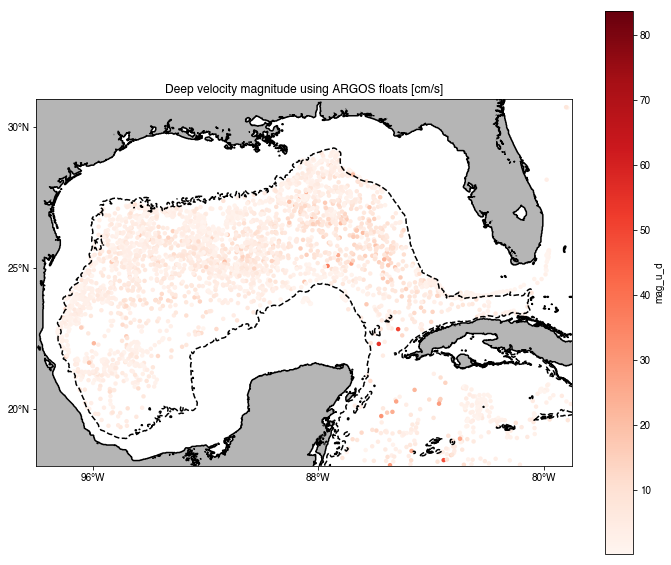

In [24]:
gulf_of_mexico = (df.lon_d>lonmin) & (df.lon_d<lonmax) & (df.lat_d>latmin) & (df.lat_d<latmax)
floats = df.loc[gulf_of_mexico]
fig, ax = plt.subplots(figsize=(12,10))


floats.plot(kind='scatter', x='lon_d', y='lat_d', c='mag_u_d', cmap='Reds',edgecolor='none', ax=ax)
ax.contour(elon,elat,ez,[-1000, 0],colors='black')
ax.contourf(elon,elat,land,np.arange(0,510,10),cmap=cm.binary)

ax.set_title('Deep velocity magnitude using ARGOS floats [cm/s]')
ax.set_aspect('equal')
fix_axes(ax, 8, 5)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)

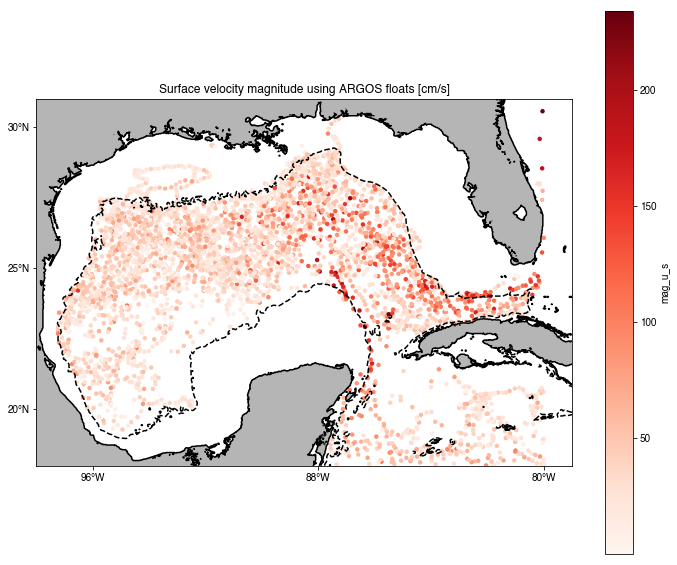

In [25]:
gulf_of_mexico_s = (df.lon_s<-80) & (df.lon_s>-98) & (df.lat_s>18) & (df.lat_s<31)
floats = df.loc[gulf_of_mexico_s]
fig, ax = plt.subplots(figsize=(12,10))

cc = floats.plot(kind='scatter', x='lon_s', y='lat_s', c='mag_u_s', cmap=cm.Reds, edgecolor='none', ax=ax)
ax.contour(elon,elat,ez,[-1000, 0],colors='black')
ax.contourf(elon,elat,land,np.arange(0,510,10),cmap=cm.binary)

ax.set_title('Surface velocity magnitude using ARGOS floats [cm/s]')
ax.set_aspect('equal')
fix_axes(ax, 8, 5)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)